In [1]:
import sys
sys.path.append("..")

import Essentials
import Visualizer_pred

In [2]:
import numpy as np
from sklearn.linear_model import HuberRegressor
from sklearn.preprocessing import StandardScaler
import Essentials
import pandas as pd
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import r2_score
from abc import ABC, abstractmethod

In [3]:
# Загрузка данных
data_archive = np.load('C:\\Users\\misha\\Makarov\\Data_Average.npz', allow_pickle=True)



In [4]:
def prepare_Y(y):
    timestamp = y[:, 1]
    y = y[:, 0].reshape(len(y), 1)
    y = y.astype(np.float64)

    return y, timestamp

ALL_column_names_1 = data_archive['column_names_1']
all_X_1 = data_archive['all_X_1']
all_Y_1 = data_archive['all_Y_1']

ALL_column_names_2 = data_archive['column_names_2_cat']
all_X_2 = data_archive['all_X_2']
all_Y_2 = data_archive['all_Y_2']

ALL_column_names_3 = data_archive['column_names_3_cat']
all_X_3 = data_archive['all_X_3']
all_Y_3 = data_archive['all_Y_3']

column_names_2 = data_archive['column_names_2']
x_summer_half_2 = data_archive['x_summer_half_2']
y_summer_half_2 = data_archive['y_summer_half_2']
x_winter_half_2 = data_archive['x_winter_half_2']
y_winter_half_2 = data_archive['y_winter_half_2']

column_names_3 = data_archive['column_names_3']
x_summer_half_3 = data_archive['x_summer_half_3']
y_summer_half_3 = data_archive['y_summer_half_3']
x_winter_half_3 = data_archive['x_winter_half_3']
y_winter_half_3 = data_archive['y_winter_half_3']

df_X1 = pd.read_csv(r'../raw_X1.csv', index_col=0)
df_X2 = pd.read_csv(r'../raw_X2.csv', index_col=0)
df_X3 = pd.read_csv(r'../raw_X3.csv', index_col=0)
df_Y1 = pd.read_csv(r'../raw_Y1.csv', index_col=0)
df_Y2 = pd.read_csv(r'../raw_Y1.csv', index_col=0)
df_Y3 = pd.read_csv(r'../raw_Y1.csv', index_col=0)

x_train, x_test, y_train, y_test=train_test_split(all_X_1, all_Y_1, test_size=0.3, random_state=42)

y_train, timestamp_train = prepare_Y(y_train)
sorted_indices_train = np.argsort(timestamp_train)
y_train = y_train[sorted_indices_train]
timestamp_train = timestamp_train[sorted_indices_train]
x_train = x_train[sorted_indices_train]

y_test, timestamp_test = prepare_Y(y_test)
sorted_indices_test = np.argsort(timestamp_test)
y_test = y_test[sorted_indices_test]
timestamp_test = timestamp_test[sorted_indices_test]
x_test = x_test[sorted_indices_test]

print(all_X_1.shape)
print(all_Y_1.shape)
print(x_train.shape)
print(y_test.shape)

x_train_winter, x_test_winter, y_train_winter, y_test_winter = train_test_split(x_winter_half_3, y_winter_half_3, test_size=0.2, random_state=42)
x_train_summer, x_test_summer, y_train_summer, y_test_summer = train_test_split(x_summer_half_3, y_summer_half_3, test_size=0.2, random_state=42)

y_train_summer, timestamp_train_summer = prepare_Y(y_train_summer)
sorted_indices_train_summer = np.argsort(timestamp_train_summer)
y_train_summer = y_train_summer[sorted_indices_train_summer]
timestamp_train_summer = timestamp_train_summer[sorted_indices_train_summer]
x_train_summer = x_train_summer[sorted_indices_train_summer]

y_train_winter, timestamp_train_winter = prepare_Y(y_train_winter)
sorted_indices_train_winter = np.argsort(timestamp_train_winter)
y_train_winter = y_train_winter[sorted_indices_train_winter]
timestamp_train_winter = timestamp_train_winter[sorted_indices_train_winter]
x_train_winter = x_train_winter[sorted_indices_train_winter]

y_test_summer, timestamp_test_summer = prepare_Y(y_test_summer)
sorted_indices_test_summer = np.argsort(timestamp_test_summer)
y_test_summer = y_test_summer[sorted_indices_test_summer]
timestamp_test_summer = timestamp_test_summer[sorted_indices_test_summer]
x_test_summer = x_test_summer[sorted_indices_test_summer]

y_test_winter, timestamp_test_winter = prepare_Y(y_test_winter)
sorted_indices_test_winter = np.argsort(timestamp_test_winter)
y_test_winter = y_test_winter[sorted_indices_test_winter]
timestamp_test_winter = timestamp_test_winter[sorted_indices_test_winter]
x_test_winter = x_test_winter[sorted_indices_test_winter]

column_names_X1 = df_X1.columns.tolist()
column_names_X2 = df_X2.columns.tolist()
column_names_X3 = df_X3.columns.tolist()
column_name_Y1 = 'Давление насыщенных паров в зимний период'
column_name_Y2 = 'Конец кипения легкого бензина'
column_name_Y3 = 'Содержание олефинов в продукте'

column_names_X1.pop()
column_names_X2.pop()
column_names_X3.pop()

feature_names_1 = column_names_X1
feature_names_2 = column_names_X2
feature_names_3 = column_names_X3

target_name_1 = column_name_Y1
target_name_2 = column_name_Y2
target_name_3 = column_name_Y3


(129, 96)
(129, 2)
(90, 96)
(39, 1)


In [5]:
class RobustLinearSoftSensor(Essentials.SoftSensor):
    def __init__(self, name, x_train, y_train, column_names):
        super().__init__(name)
        self.name = name
        self.column_names = column_names  # Добавляем список названий признаков
        self.train(x_train, y_train)  

    def preprocessing(self, x):
        return x

    def postprocessing(self, pred_values):
        if pred_values.ndim == 1:
            pred_values = pred_values.reshape(-1, 1)
        return pred_values

    def evaluate_model(self, x):
        if self.get_model() is None:
            raise ValueError("Model is not trained yet.")
        return self.get_model().predict(x)

    def train(self, x_train, y_train):
        self.set_model(HuberRegressor())
        self.get_model().fit(x_train, y_train)
        self.r2_score = self.get_model().score(x_train, y_train)
        self.coefficients = self.get_model().coef_

    def __str__(self):
        if self.get_model() is not None:
            # Форматирование названий признаков и коэффициентов для вывода
            max_len = max(len(name) for name in self.column_names)
            coefs_str = "\n".join(
                [f"{name.ljust(max_len)}: {coef:.4f}" for name, coef in zip(self.column_names, self.coefficients)]
            )
            
            return (f"Robust Linear Soft Sensor '{self.name}':\n"
                    f"Коэффициенты:\n{coefs_str}\n"
                    f"R^2 score: {self.r2_score:.4f}")
        else:
            return "Robust Linear Soft Sensor Model has not been trained yet."

In [6]:
sensor = RobustLinearSoftSensor("Robust Sensor", x_train, y_train, column_names=ALL_column_names_1)

c:\Users\misha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\misha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [7]:
print(sensor)

Robust Linear Soft Sensor 'Robust Sensor':
Коэффициенты:
Расход бензина ККР на установку           : 0.0785
Расход нафты ККР на установку             : -0.0996
Расход бензина на рециркуляцию от Е-1205  : -0.0499
Температура бензина ККР на установку      : 0.0451
Расход сырья после Р-1101                 : 0.0179
Показатель соотношения водород к углероду : 0.0017
Расход водорода на смешение перед Е-1101  : -0.0060
Температура сырья перед Е-1101            : 0.0455
Давление сырья перед Е-1101               : 0.0096
Температура сырья перед Е-1102            : 0.0035
Температура сырья перед Е-1103            : 0.0455
Давление сырья перед Е-1103               : 0.0097
Температура сырья после Е-1103            : 0.0765
Температура ТБ перед Е-1101               : 0.0052
Давление ТБ перед Е-1101                  : 0.0063
Температура ТБ после Е-1101               : 0.0095
Температура бензина перед Е-1102          : 0.0853
Температура бензина после Е-1102          : 0.0483
Давление бензина после

In [8]:
metric = Essentials.R2Metric()

In [9]:
test_visual_1 = Essentials.Visualizer(x_train, y_train, timestamp_train, [metric], 'Test SoftSensor R2 metric')

               Coefficient of determination
Robust Sensor                      0.691471


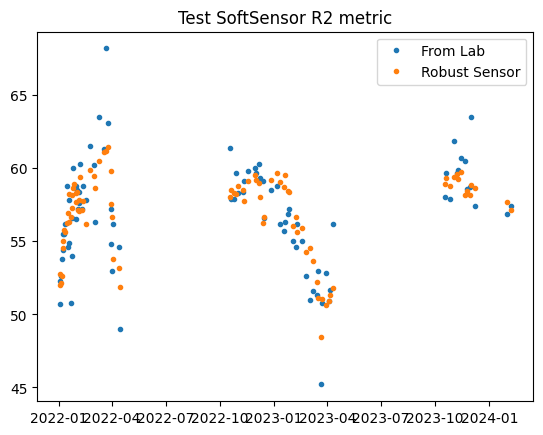

In [10]:

test_visual_1.visualize([sensor])

+---------------+--------------------------------+---------+
|               |   Coefficient of determination |     MSE |
+===============+================================+=========+
| Robust Sensor |                       0.630343 | 4.69803 |
+---------------+--------------------------------+---------+


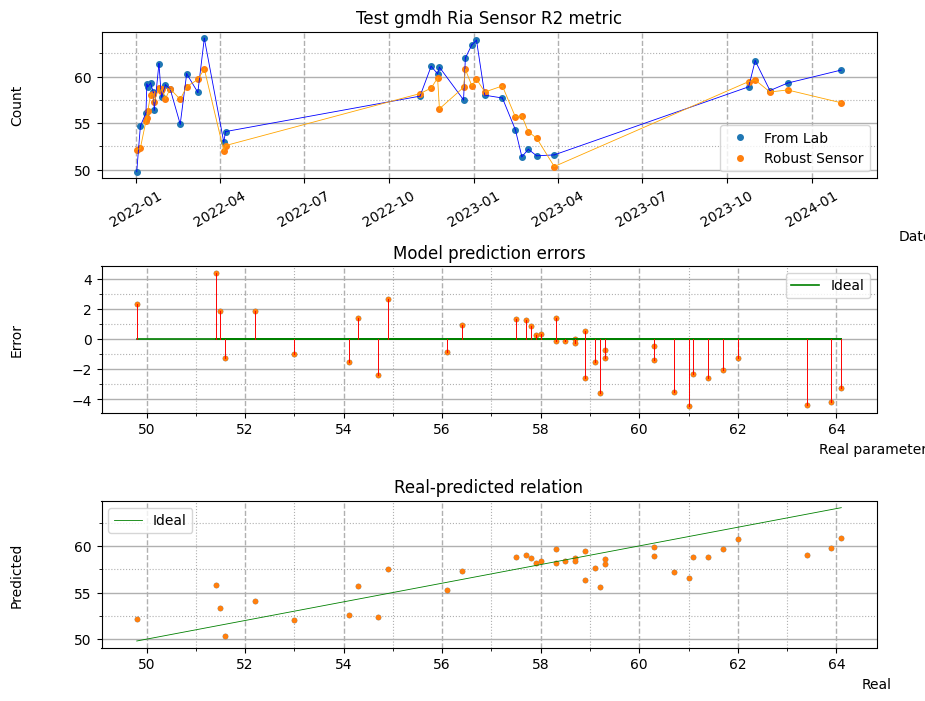

In [11]:
test_visual=Visualizer_pred.Visualizer(x_test, y_test, timestamp_test,[metric], 'Test gmdh Ria Sensor R2 metric')
test_visual.visualize([sensor], lines=True, lines_vertical=True)